# **App Success Prediction Project**

**Business Understanding**

The goal of this project is to create a model that predicts the success of mobile applications based on various features, including category, install count, and user ratings. Understanding the characteristics that contribute to an app’s popularity enables informed decisions for app developers and marketers on how to enhance app performance, boost installs, and improve user engagement. The business objective is to guide app development strategies and marketing campaigns to increase app downloads, improve user ratings, and, ultimately, maximize app success across different categories and demographic segments.

**Key Business Questions:**

* What app categories, pricing models, and content ratings attract the highest number of installs?
* How do factors like app size, content rating, and category impact user ratings and overall app success?
* Can we identify the features that most significantly differentiate high-performing apps from others?

**Metric of Success**

The success of this model will be measured using the macro F1-score, with a target threshold of 0.7. This metric ensures that the model maintains a balanced performance across all app success categories—Low, Medium, and High—by equally weighting precision and recall for each class. Reaching this target score indicates that the model can reliably distinguish between different levels of app success, making it a valuable tool for guiding app development and marketing strategies.



##  **1. Data Exploration**

###1.1 Loading and Basic Information

In this section, we load the dataset and **display** the basic information.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/data.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


**Initial Overview**
- The dataset contains information on mobile apps, including categories, user ratings, and installation counts among others.
- Some columns may contain missing values, which we’ll handle in the next steps.
- The data types include both numeric and categorical variables, which will influence our preprocessing steps.


###1.2 Missing Values Analysis

In [ ]:
# Percentages of missing values in each column
missing_values= df.isnull().sum()
missing_values= missing_values[missing_values>0].sort_values(ascending=False)

percent_missing= missing_values*100/len(df)
percent_missing= percent_missing[percent_missing>0].round(2)

missing_df= pd.DataFrame({'missing_values': missing_values, 'percent_missing': percent_missing})
missing_df



,missing_values,percent_missing
Rating,1474,13.60
Current Ver,8,0.07
Android Ver,3,0.03
Type,1,0.01
Content Rating,1,0.01


**Insights**
- **Rating**: Around 13.6% of the values in this column are missing.
- **Current Ver**, **Android Ver**, **Type**, and **Content Rating**: These columns have negligible missing values (under 0.1%).

In [ ]:
# Median imputation for Rating
df.fillna({'Rating': df['Rating'].median()}, inplace=True)

# Mode imputation for other columns with minimal missing values
for column in ['Current Ver', 'Android Ver', 'Type', 'Content Rating']:
    df.fillna({column: df[column].mode()[0]}, inplace=True)

In [ ]:
df.isnull().sum()

,0
App,0
Category,0
Rating,0
Reviews,0
Size,0
Installs,0
Type,0
Price,0
Content Rating,0
Genres,0


To ensure the dataset is complete and usable for analysis, we applied the following imputation techniques:

- **Rating**: Since this is a numeric and essential feature, we used median imputation to handle its missing values. This approach minimizes the impact of outliers and retains a central tendency reflective of the overall data.
- **Current Ver, Android Ver, Type, and Content Rating**: Given the low percentage of missing values in these categorical columns, we used mode imputation to replace the missing values with the most frequent category. This method preserves the original distribution of these features.

These steps prepare our data for exploration and modeling without compromising data integrity.


### 1.3 Converting datatypes
To improve processing efficiency, we adjusted data types in our dataset

In [ ]:
df.dtypes

,0
App,object
Category,object
Rating,float64
Reviews,object
Size,object
Installs,object
Type,object
Price,object
Content Rating,object
Genres,object


In [ ]:
# Convert 'Reviews' to numeric, removing rows with missing values in 'Reviews'
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df.dropna(subset=['Reviews'], inplace=True)

# Clean 'Installs' column by removing symbols and converting to numeric, removing any resulting NaN values
df['Installs'] = pd.to_numeric(df['Installs'].str.replace('+', '').str.replace(',', ''), errors='coerce')
df.dropna(subset=['Installs'], inplace=True)

# Remove '$' in 'Price' and convert to float
df['Price'] = pd.to_numeric(df['Price'].str.replace('$', ''), errors='coerce')


In [ ]:
# Function to convert size to MB
def convert_size(size):
    if size == 'Varies with device':
        return 'Varies'
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    return None

# Apply the conversion function
df['Size_MB'] = df['Size'].apply(convert_size)

# Display the resulting DataFrame
df[['Size', 'Size_MB']]

,Size,Size_MB
0,19M,19.0
1,14M,14.0
2,8.7M,8.7
3,25M,25.0
4,2.8M,2.8
...,...,...
10836,53M,53.0
10837,3.6M,3.6
10838,9.5M,9.5
10839,Varies with device,Varies


- **Reviews**: Converted to numeric, as it initially had string entries. Any rows where conversion resulted in NaN values were removed.
- **Installs**: Removed extraneous symbols (`+`, `,`) and converted to numeric type. We dropped any rows with missing values after conversion.
- **Price**: Removed the `$` symbol and converted the feature to a float type for accurate numeric operations.
- **Size**: Converted Size to 'MB', assuming 'M' represented megabytes and 'K' kilobytes.

These steps ensure that `Reviews`, `Installs`,`Price`  and `Size`are ready for analysis and visualization as numeric data.


###1.4 Unique Values

- Viewed unique values for each categorical feature, to reveal any inconsistencies or potential categories for encoding.

In [ ]:
categorical_columns = ['Category', 'Type', 'Content Rating']
for column in categorical_columns:
  unique_values = df[column].unique()
  print(f"Unique values in column '{column}'")
  print(unique_values)
  print()


Unique values in column 'Category'
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']

Unique values in column 'Type'
['Free' 'Paid']

Unique values in column 'Content Rating'
['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']



**Insights:**

'Category':The dataset contains a wide variety of app categories, indicating a diverse range of applications available in the market.

'Type': The presence of "Free" and "Paid" indicates the monetization strategy of the apps.

'Content Rating': The different content ratings suggest that the apps cater to various age groups, which can be a crucial factor for user demographics.

## **2. Exploratory Data Analysis**
In this step, we aim to uncover key insights about the data by exploring individual features (univariate analysis), relationships between two features (bivariate analysis), and interactions among three or more features (multivariate analysis). This will provide a solid foundation for understanding patterns that could help predict app success.

### 2.1 **Univariate Analysis**

We'll focus on understanding the distribution of each feature in isolation

#### 2.1.1 Rating

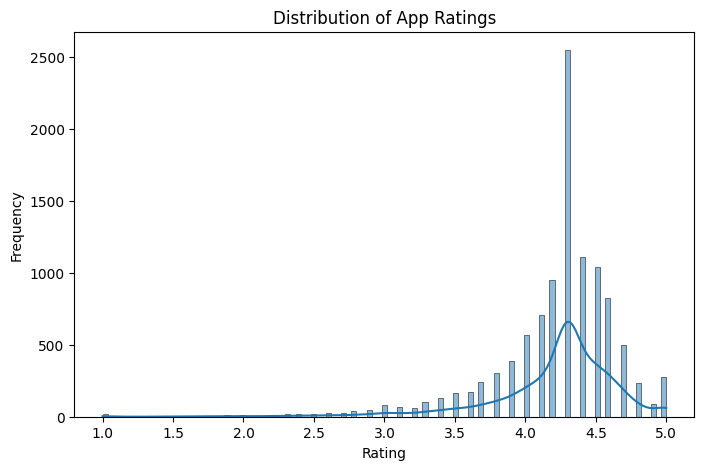

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


Most apps have high ratings, clustering around the median of 4.3, with relatively few apps rated below 4.0. This skew towards higher ratings may indicate a positive bias in user ratings or that app quality is generally high.

#### 2.1.2 Number of Installations

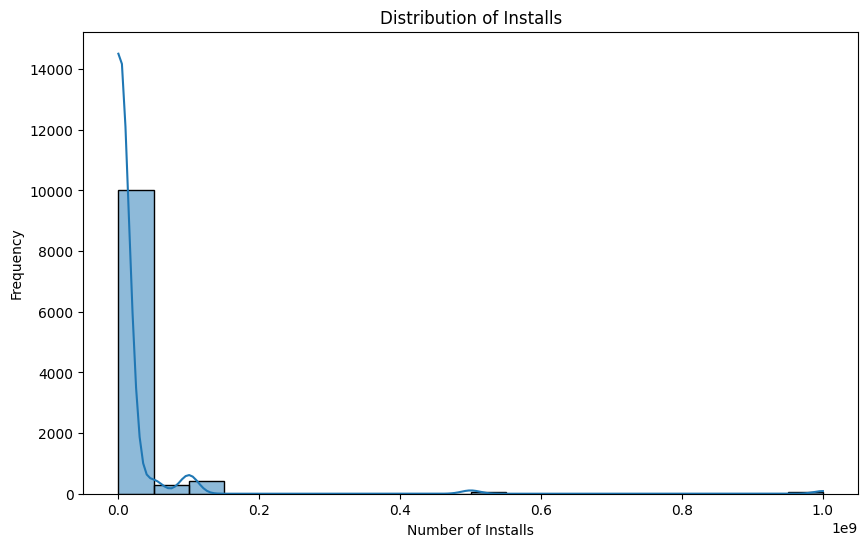

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Installs'], bins=20, kde=True)
plt.title('Distribution of Installs')
plt.xlabel('Number of Installs')
plt.ylabel('Frequency')
plt.show()

The distribution of Installs is highly skewed to the right, indicating that while a significant number of apps have low install counts, there are a few outliers with very high install numbers.

#### 2.1.3 Type(License)

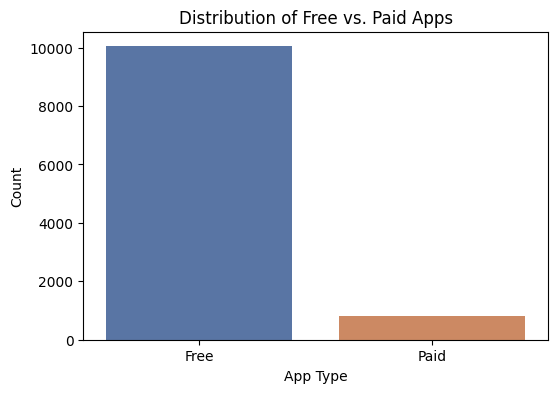

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Type', data=df, hue='Type',palette='deep')
plt.title('Distribution of Free vs. Paid Apps')
plt.xlabel('App Type')
plt.ylabel('Count')
plt.show()


The majority of apps are free, which aligns with common app store trends. Paid apps, though fewer, could represent specialized or premium content.

#### 2.1.4 App Categories

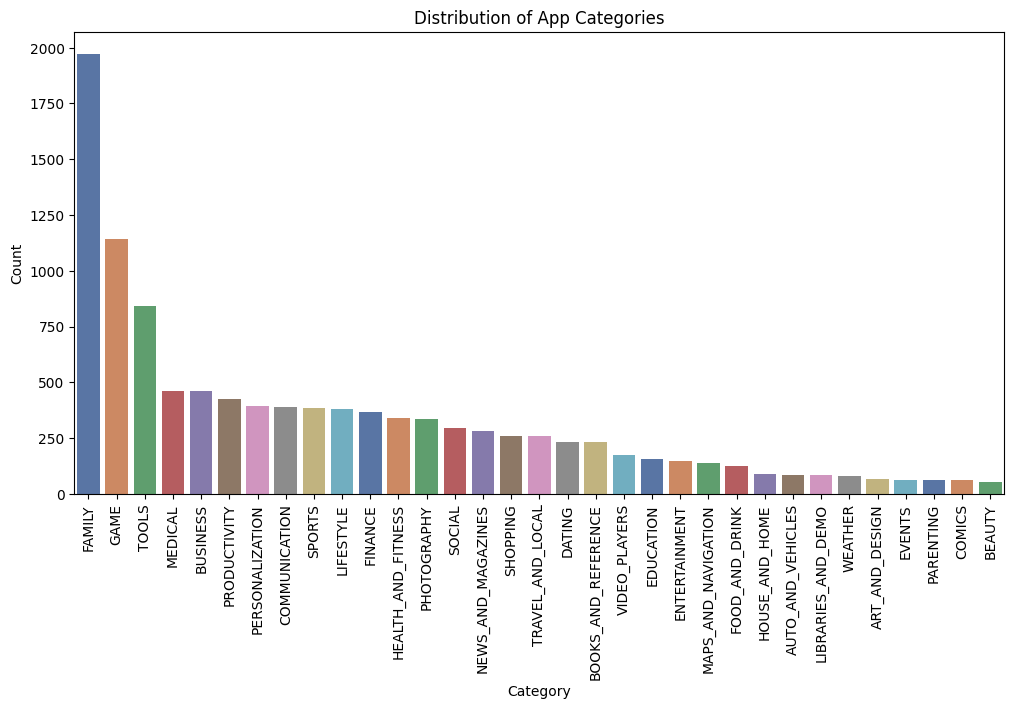

In [ ]:
category_counts = df['Category'].value_counts().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='deep', legend=False)
plt.title('Distribution of App Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



The bar plot of app counts by category reveals a varied distribution across categories, with FAMILY and GAME being the most prevalent, hosting 1,972 and 1,144 apps respectively, indicating high developer focus.

In contrast, categories like COMICS, BEAUTY, and PARENTING have far fewer apps, suggesting either niche markets or lower developer focus.

#### 2.1.5 Content Rating(App Audience)

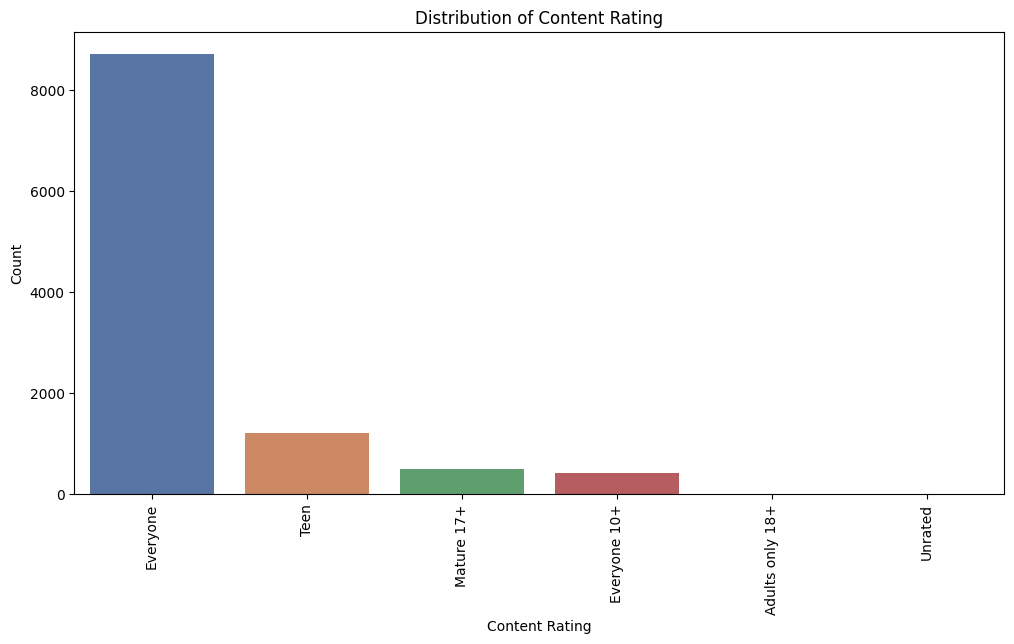

In [ ]:
#Distribution of content Rating
cr_counts= df['Content Rating'].value_counts().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=cr_counts.index, y=cr_counts.values, hue=cr_counts.index, palette='deep', legend=False)
plt.title('Distribution of Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

The distribution of Content Rating shows that most apps target a general audience, with 8,714 rated Everyone, indicating a preference for broad accessibility. Teen (1,208) and Mature 17+ (499) apps are the next most common, catering to older audiences but still considerably fewer than Everyone. Ratings like Adults only 18+ (3) and Unrated (2) are rare, suggesting minimal focus on strictly adult content.

#### 2.1.6 Price

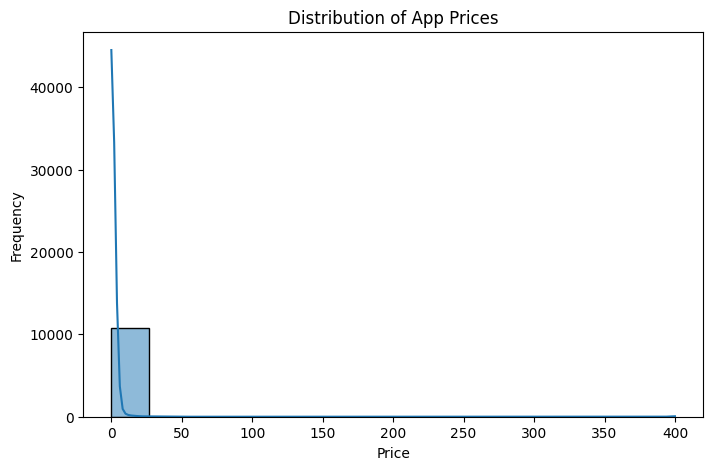

In [ ]:
#Plot distribution of price
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of App Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The histogram of Price reveals a highly skewed distribution with a significant number of free apps (indicated by a price of $0$). Most apps fall within the $0$ range, while a few have prices that extend up to $400, indicating a long tail.

This distribution highlights the predominance of free applications in the dataset, with a relatively small segment of expensive options.

#### 2.1.7 App Size


In [ ]:
#Distribution of App sizes
size_counts= df['Size_MB'].value_counts()
size_counts

,count
Size_MB,
Varies,1695
11.0,198
12.0,196
14.0,194
13.0,191
...,...
0.43,1
0.429,1
0.2,1


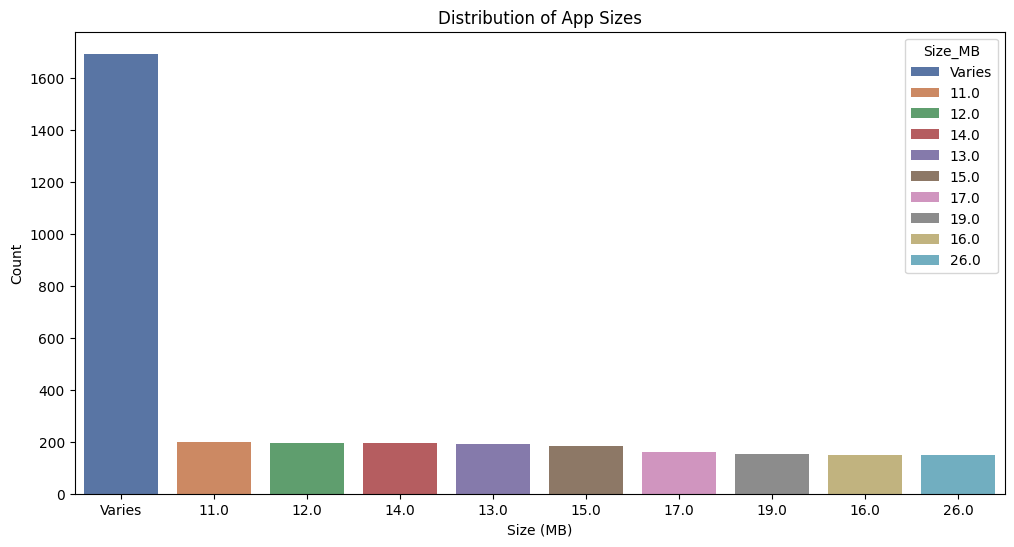

In [ ]:
#filter to top 10 and plot
top_10_sizes = size_counts.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_sizes.index, y=top_10_sizes.values,hue=top_10_sizes.index, palette='deep')
plt.title('Distribution of App Sizes')
plt.xlabel('Size (MB)')
plt.ylabel('Count')
plt.show()

The size distribution shows a notable reliance on smaller app sizes, which could reflect user preferences for quick downloads and efficient performance. The dominance of "Varies" suggests that a significant number of apps are tailored to different devices, indicating flexibility in design. The range of fixed sizes also suggests that developers are optimizing app performance and user experience by adhering to commonly accepted size benchmarks, balancing features and resource demands.

### 2.2 **Bivariate Analysis**
In this section, we will explore relationships between two variables at a time to understand how they interact with Installs, our target variable. We will primarily focus on visualizations and statistical measures.

#### 2.2.1 Rating vs Installs

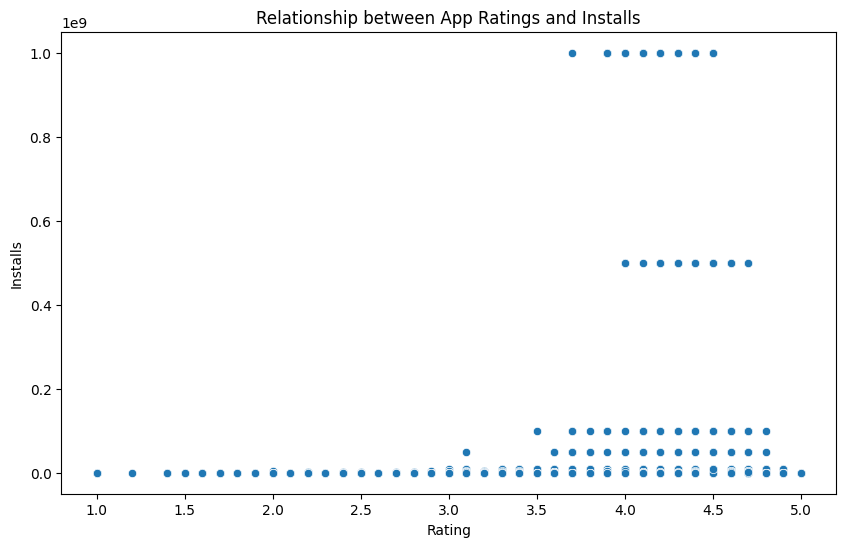

In [ ]:
# Visualization: ScatterPlot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Installs', data=df)
plt.title('Relationship between App Ratings and Installs')
plt.xlabel('Rating')
plt.ylabel('Installs')
plt.show()

The lack of a clear upward or downward trend suggests that other factors may influence the number of installs beyond just the app rating.

The clustering could indicate that many apps receive similar ratings, but their install counts vary due to external influences.

#### 2.2.2 Price vs Installs

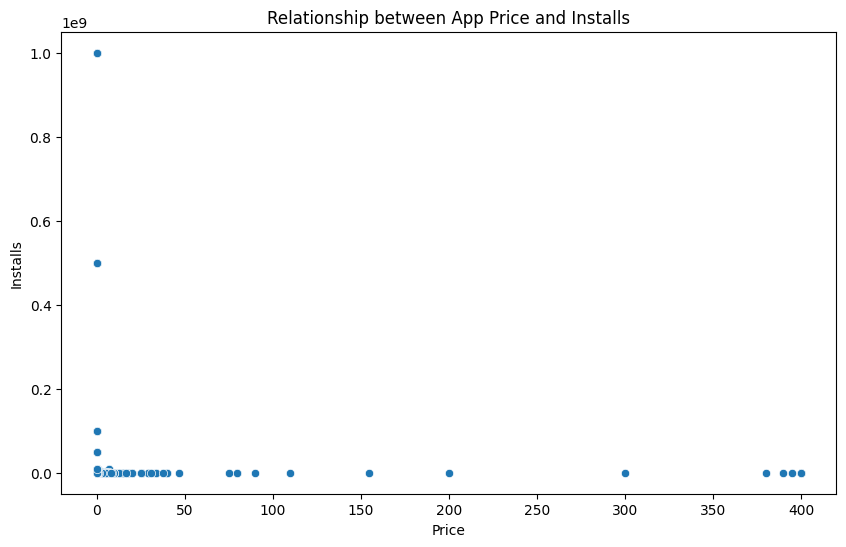

In [ ]:
#Visualization: Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Installs', data=df)
plt.title('Relationship between App Price and Installs')
plt.xlabel('Price')
plt.ylabel('Installs')
plt.show()

The L-shaped distribution in the scatter plot indicates a strong preference for free apps among users, with a relatively small market for paid applications. This insight can inform strategies for pricing, marketing, and potentially the development of features that add value to justify higher prices.

#### 2.2.3 Type vs Installs

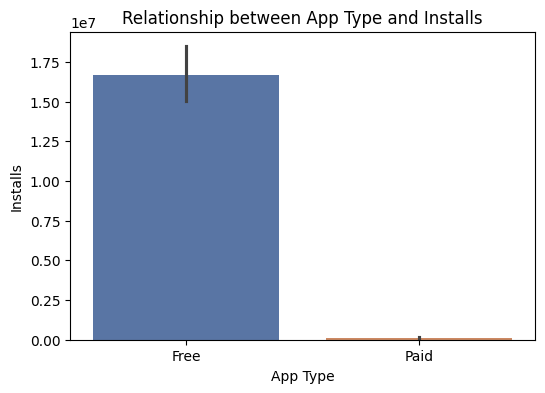

In [ ]:
#Visualization: barplot
plt.figure(figsize=(6, 4))
sns.barplot(x='Type', y='Installs', data=df, hue='Type', palette='deep')
plt.title('Relationship between App Type and Installs')
plt.xlabel('App Type')
plt.ylabel('Installs')
plt.show()

This distribution suggests that the app type plays a significant role in an app’s potential install count.

It reinforces the previous observation that, free apps tend to attract more users, while paid apps may require higher perceived value to achieve significant downloads.


#### 2.2.4 Category vs Installs

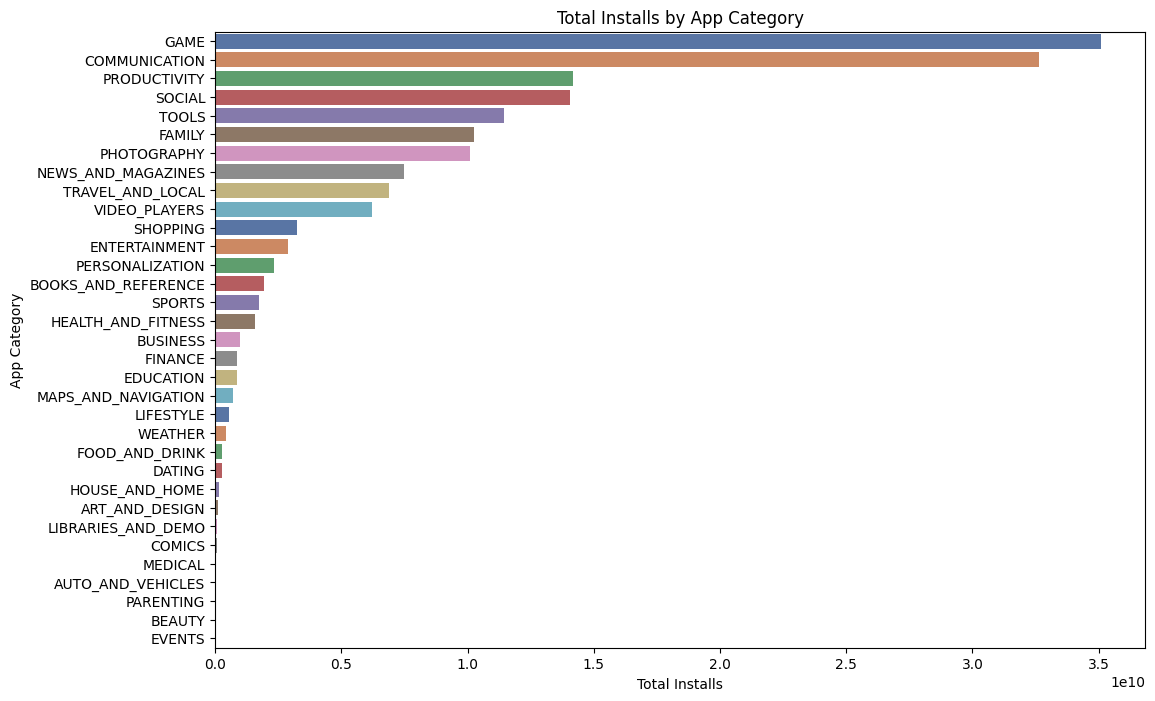

In [ ]:
# Aggregating installs by category
category_installs = df.groupby('Category')['Installs'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=category_installs.values, y=category_installs.index, hue=category_installs.index, palette='deep')
plt.title('Total Installs by App Category')
plt.xlabel('Total Installs')
plt.ylabel('App Category')
plt.show()

The distribution of installs shows that Games and Communication apps dominate, with Productivity and Social apps also attracting high user engagement. Categories like Tools, Family, and Photography have moderate installs, reflecting steady utility and informational demand. At the lower end, Events, Beauty, and Medical apps attract niche user interest, highlighting specialized appeal. This breakdown guides developers on which categories attract the most installs, informing app strategy for higher visibility and engagement.

#### 2.2.5 Content Rating vs Installs

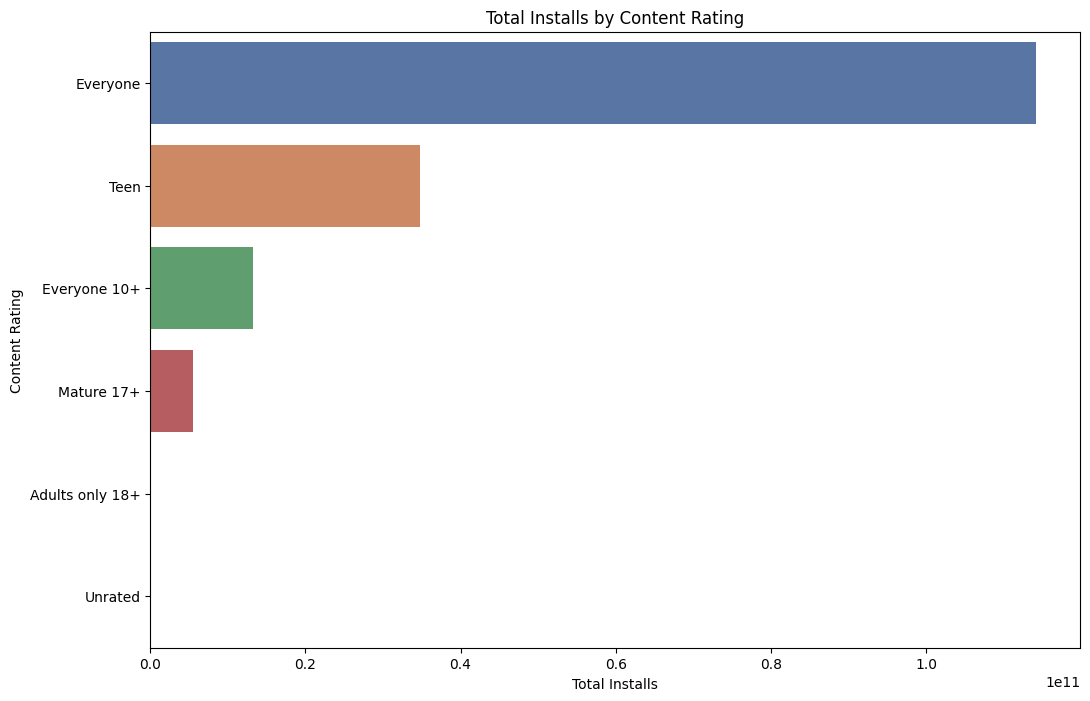

In [ ]:
# Aggregating installs by Content Ratting
content_rating_installs = df.groupby('Content Rating')['Installs'].sum().sort_values(ascending=False)

#plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=content_rating_installs.values, y=content_rating_installs.index, hue=content_rating_installs.index, palette='deep')
plt.title('Total Installs by Content Rating')
plt.xlabel('Total Installs')
plt.ylabel('Content Rating')
plt.show()


Apps rated Everyone have the highest installs, showing broad appeal and accessibility across all age groups, followed by Teen and Everyone 10+ rated apps, which also draw significant installs.

Mature 17+ apps attract a smaller yet notable user base, appealing to a more selective audience.

Adults only 18+ and Unrated apps have minimal installs, indicating limited engagement, likely due to restricted age suitability or undefined content rating.

This distribution emphasizes the importance of age-appropriate ratings for maximizing app reach and installs.

### 2.3 **Multivariate Analysis**
Multivariate analysis helps explore interactions between multiple features, providing a deeper understanding of complex relationships in the dataset.

#### 2.3.1 Installs vs Category vs Type

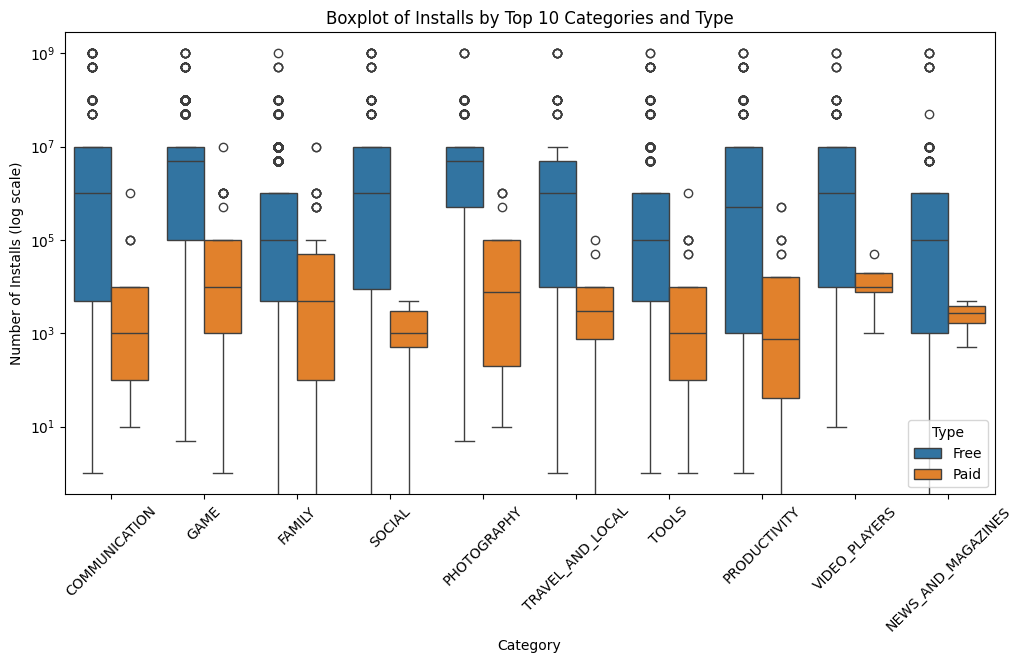

In [ ]:
# Group by 'Category' and 'Type' to get the top 10 categories by total installs
top_categories = df.groupby('Category')['Installs'].sum().nlargest(10).index
filtered_df = df[df['Category'].isin(top_categories)]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='Category', y='Installs', hue='Type')
plt.title('Boxplot of Installs by Top 10 Categories and Type')
plt.xticks(rotation=45)
plt.yscale('log')  # Using log scale for better visibility
plt.xlabel('Category')
plt.ylabel('Number of Installs (log scale)')
plt.legend(title='Type')
plt.show()

The boxplot of installs by the top 10 categories and type reveals significant variability in app popularity across categories. The Communication category leads in median installs, with a wide interquartile range indicating diverse performance. Family and Game categories also show substantial installs, while Tools, Travel and Local, and Video Players have lower median counts. Free apps generally attract more installs than Paid apps, highlighting a competitive landscape where a few top performers skew the distribution upward.

#### 2.3.2 Installs by Content Rating and Type

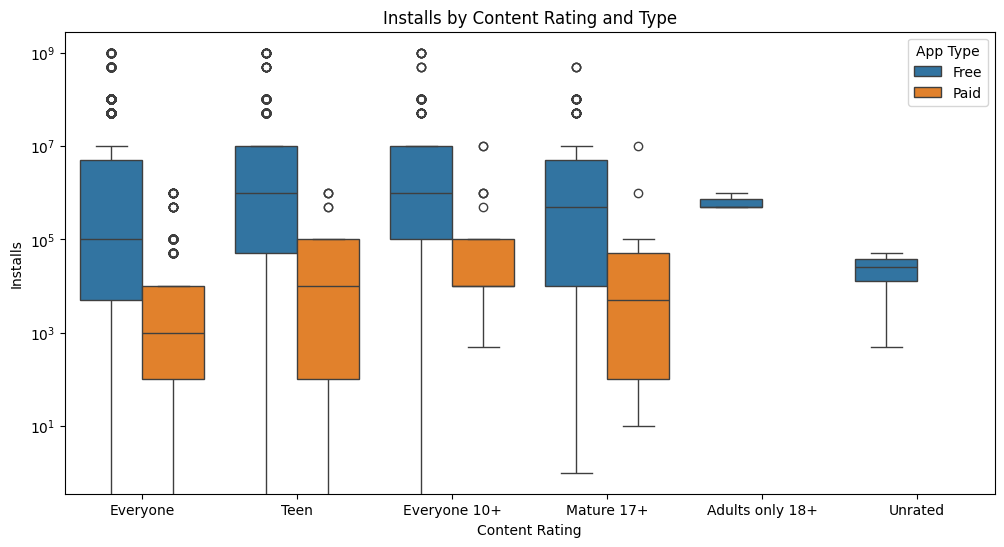

In [ ]:
# Boxplot of Installs by Content Rating and Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Content Rating', y='Installs', hue='Type', data=df)
plt.yscale('log')
plt.title('Installs by Content Rating and Type')
plt.xlabel('Content Rating')
plt.ylabel('Installs')
plt.legend(title='App Type')
plt.show()


The boxplot of installs by content rating and type reveals that apps rated "Everyone" significantly outperform others in total installs, with a substantial median and wide interquartile range, indicating diverse performance.

In contrast, "Teen" and "Mature 17+" ratings show lower median installs, with the "Adults only 18+" category having the fewest installs, highlighting a limited audience.

 Free apps across all content ratings dominate in installs compared to their paid counterparts, reinforcing the trend observed in other analyses.

## **3. Data Preprocessing**

### 3.1 **Feature Engineering**
In this section, we created new features,where:

`min_android_version`: Extracts the minimum Android version to provide more meaningful information than the string "4.4 and up".

`size_category`: Groups app sizes into categories to be inclusive of the "varies with device" option and make them easier to process.

`install_category`: Bins install_count into categories (e.g., Low, Medium, High) to reduce the impact of outliers and for better classification of app success.




#### 3.1.1 Extracting Minimum Android Version

In [ ]:
df['Android Ver'].value_counts().head()

,count
Android Ver,
4.1 and up,2453
4.0.3 and up,1501
4.0 and up,1375
Varies with device,1362
4.4 and up,980


In [ ]:
import re
def extract_min_android_version(version):
    # Check if the entry is "Varies with device"
    if version == 'Varies with device':
        return 0  # Assign a specific value to represent this category
    # Extract the minimum version using regex
    match = re.match(r'(\d+\.\d+)', version)
    if match:
        return float(match.group(1))  # Convert to float for numerical operations
    return None  # Fallback for unexpected formats

# Apply extraction
df['Min Android Ver'] = df['Android Ver'].apply(extract_min_android_version)


df[['Android Ver', 'Min Android Ver']]

,Android Ver,Min Android Ver
0,4.0.3 and up,4.0
1,4.0.3 and up,4.0
2,4.0.3 and up,4.0
3,4.2 and up,4.2
4,4.4 and up,4.4
...,...,...
10836,4.1 and up,4.1
10837,4.1 and up,4.1
10838,2.2 and up,2.2
10839,Varies with device,0.0


In [ ]:
df['Min Android Ver'].value_counts(10)

,proportion
Min Android Ver,
4.0,0.265498
4.1,0.226384
0.0,0.125646
4.4,0.091513
2.3,0.086070
5.0,0.055812
4.2,0.036347
2.2,0.022601
4.3,0.022417


- Android 4.0 and 4.1 are the most common minimum versions, with 2878 and 2454 apps, respectively.

- Version 0.0 represents "Varies with device," totaling 1362 apps where the required version depends on the device specifications.

- Lower Android versions (like 2.3 and 2.2) still appear, indicating compatibility with older devices, while newer versions like 7.0 and 8.0 have fewer apps, suggesting lower support for recent Android releases in the dataset.

This distribution highlights app compatibility across various Android versions, from legacy (1.0) to modern releases, with a notable concentration around version 4.x.

#### 3.1.2 Categorizing Size

In [ ]:
# Group size into 4 categories inclusive of "varies"
def categorize_size(size):
    if size == 'Varies':
        return 'Varies'
    elif size <= 10:
        return 'Small'
    elif size <= 50:
        return 'Medium'
    elif size <= 200:
        return 'Large'
    else:
        return 'Very Large'

# Apply the function to create the 'Size_Category' column
df['Size_Category'] = df['Size_MB'].apply(categorize_size)
df[['Size_MB', 'Size_Category']]

,Size_MB,Size_Category
0,19.0,Medium
1,14.0,Medium
2,8.7,Small
3,25.0,Medium
4,2.8,Small
...,...,...
10836,53.0,Large
10837,3.6,Small
10838,9.5,Small
10839,Varies,Varies


In [ ]:
df['Size_Category'].value_counts()

,count
Size_Category,
Small,4060
Medium,4011
Varies,1695
Large,1074


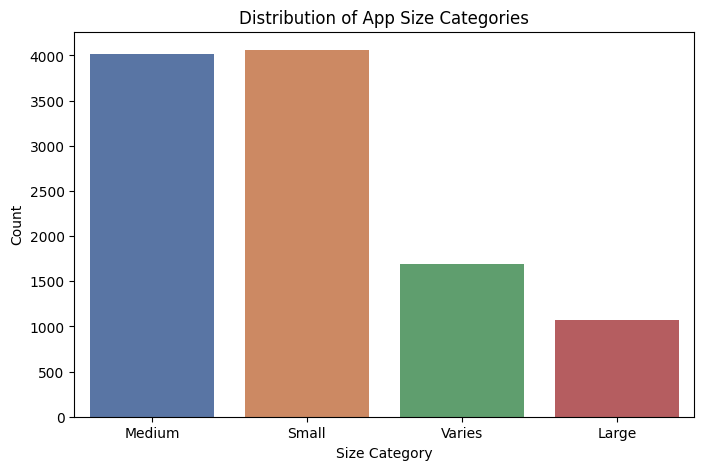

In [ ]:
#plot of size_category distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Size_Category', data=df, hue='Size_Category', palette='deep')
plt.title('Distribution of App Size Categories')
plt.xlabel('Size Category')
plt.ylabel('Count')
plt.show()

The Size_Category column classifies app sizes into four categories:

- Small (≤10 MB): Contains 4060 apps, representing lightweight apps.

- Medium (10–50 MB): Includes 4011 apps, covering moderate-size apps.

- Large (50–200 MB): Encompasses 1074 apps, indicating apps with larger file sizes.

- Varies: Represents 1695 apps where size depends on the device, maintaining the original "Varies" classification.

This categorization provides a clear view of app size distribution, making it easier to analyze and compare app sizes across standardized groups.

#### 3.1.3 Binning Installs

In [ ]:
#Binning installsinto three categories(low, medium and high) using quartile method
install_bins = [0, 1000000, 10000000, float('inf')]
install_labels = ['Low', 'Medium', 'High']

df['Install_Category'] = pd.qcut(df['Installs'], q=3, labels=['Low', 'Medium', 'High'])
df[['Installs', 'Install_Category']].head()

,Installs,Install_Category
0,10000,Low
1,500000,Medium
2,5000000,High
3,50000000,High
4,100000,Medium


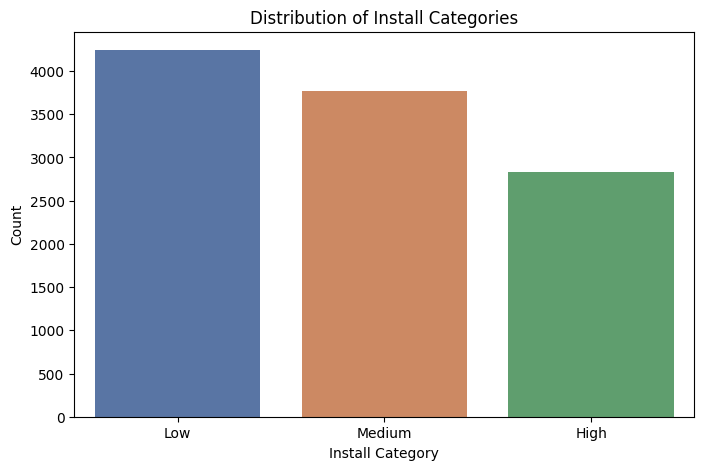

In [ ]:
#plot distribution of the categories
plt.figure(figsize=(8, 5))
sns.countplot(x='Install_Category', data=df, hue='Install_Category', palette='deep')
plt.title('Distribution of Install Categories')
plt.xlabel('Install Category')
plt.ylabel('Count')
plt.show()

In this step, the Installs feature has been binned into three categories (Low, Medium, and High) using the quartile method.

The "Install_Category" column was created by dividing the install counts into three equal-frequency groups based on the distribution of the data.
- Low: Represents apps with installs in the lower third of the distribution.
- Medium: Represents apps in the middle third.
- High: Represents apps with installs in the top third.

This categorization provides an easy way to interpret the popularity of an app in terms of install count, helping to simplify analysis and comparisons.

#### 3.1.4 Drop unnecessary columns
- App:

The app name does not add predictive power regarding install success, as it is not directly related to any trend or measurable characteristic.

Dropping reduces unnecessary dimensionality without loss of predictive insights
- last_updated:

This column could be useful for tracking the frequency of updates, which might influence app popularity. However, it lacks detailed timestamps needed for calculating meaningful update patterns.

With detailed timestamps, update frequency could be engineered, but without them, it’s best to drop.
- current_version:

On its own, current_version is not informative about app performance. While versioning could provide insights if paired with timestamps (e.g., change rate), it doesn’t offer value alone.

Dropping this avoids noise since timestamps for tracking version changes are unavailable.
- genres:

Genre information is often redundant when a broader category (e.g., category) is available. Using both could add unnecessary noise due to high cardinality.

The category column is more general and captures similar insights.
- size, size_MB and install_count

Since size_category and install_category have been created to represent size and installs effectively, these columns become redundant.

Used size_category  and install_category as concise and informative features.
- reviews_count

reviews_count reflect an app's post-launch performance, relying on user feedback after release. Since we aim to predict app success before launch, we exclude these features to avoid data leakage and focus only on pre-launch characteristics.



In [ ]:
df.drop(['App', 'Last Updated', 'Current Ver', 'Genres', 'Size', 'Installs', 'Reviews', 'Android Ver', 'Size_MB'], axis=1, inplace=True)
df.head()

,Category,Rating,Type,Price,Content Rating,Min Android Ver,Size_Category,Install_Category
0,ART_AND_DESIGN,4.1,Free,0.0,Everyone,4.0,Medium,Low
1,ART_AND_DESIGN,3.9,Free,0.0,Everyone,4.0,Medium,Medium
2,ART_AND_DESIGN,4.7,Free,0.0,Everyone,4.0,Small,High
3,ART_AND_DESIGN,4.5,Free,0.0,Teen,4.2,Medium,High
4,ART_AND_DESIGN,4.3,Free,0.0,Everyone,4.4,Small,Medium


### 3.2 **Feature Encoding**
In this step, we'll encode categorical features, converting them into a format interpretable by algorithms.

#### 3.2.1 Binary Encoding
Here we'll create a custom transformer for binary encoding using ```category_encoders```



In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce

class BinaryEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = ce.BinaryEncoder(cols=self.cols)

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X):
        return self.encoder.transform(X)


#### 3.2.2 Ordinal Encoding
To prepare categorical features with a low number of unique values for modeling, we applied Ordinal Encoding. This encoding method assigns each unique category a distinct integer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder

# Custom transformer using OrdinalEncoder for label features
class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        # Fit the OrdinalEncoder on selected columns only
        self.encoder.fit(X[self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Transform the selected columns
        X_copy[self.cols] = self.encoder.transform(X_copy[self.cols])
        return X_copy


- **Original Features:** Maintaining the original categorical features allows for easy reference and interpretability when analyzing the model's results.
- **Encoded Features:** The newly created features are ready for input into machine learning algorithms, ensuring that the categorical variables are represented in a suitable numerical format.

### 3.3 **Feature Scaling**
This step is meant to convert numerical features into the scale.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
df.head()

,Category,Rating,Type,Price,Content Rating,Min Android Ver,Size_Category,Install_Category
0,ART_AND_DESIGN,4.1,Free,0.0,Everyone,4.0,Medium,Low
1,ART_AND_DESIGN,3.9,Free,0.0,Everyone,4.0,Medium,Medium
2,ART_AND_DESIGN,4.7,Free,0.0,Everyone,4.0,Small,High
3,ART_AND_DESIGN,4.5,Free,0.0,Teen,4.2,Medium,High
4,ART_AND_DESIGN,4.3,Free,0.0,Everyone,4.4,Small,Medium


## **4. Modelling**
This phase focuses on building predictive models to classify mobile app success (Low, Medium, or High installs) using insights from our data. We'll explore various machine learning algorithms, including Logistic Regression, Random Forest, XGBoost, LightGBM, and a Neural Network. Our primary success metric is the macro F1-score, ensuring balanced performance across all success categories. We'll fine-tune models, evaluate them, and select the best performer for real-time app success prediction, empowering data-driven decisions

In [ ]:
!pip install imblearn scikit-learn xgboost lightgbm dask[dataframe] tensorflow

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, label_binarize
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from lightgbm import LGBMClassifier
import joblib

### 4.1 **Define Features and Target Variable**
- The features consist of various application attributes, including categorical variables (e.g., Category ) and numerical variables (e.g., Min Android Ver).
- The target variable for this classification task is `Install_Category`, representing the success level of the applications.

In [ ]:
#Prepare data
X = df.drop(columns= 'Install_Category')
y = df['Install_Category']

#Encode target variable
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


### 4.3 **Preprocessing Pipeline**
The Preprocessing pipelines previously created will be used to handle different types of features:
- Binary Encoding for Category and Content Rating, which reduces dimensionality.
- Ordinal Encoding for categorical features such as Type and Size_Category.
- Standard Scaling for numerical features to standardize their range.

In [ ]:
# Specify categorical and numerical columns
binary_features = ['Category', 'Content Rating']
label_features = ['Type', 'Size_Category']
numerical_features = ['Rating', 'Price', 'Min Android Ver']

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('binary_encoder', BinaryEncoderTransformer(cols=binary_features), binary_features),
        ('ordinal_encoder', OrdinalEncoderTransformer(cols=label_features), label_features),
        ('numeric_scaler', numeric_transformer, numerical_features)
    ], remainder='drop'
)

In [99]:
# Save custom transformers
joblib.dump(BinaryEncoderTransformer, 'binary_encoder_transformer.joblib')

['binary_encoder_transformer.joblib']

In [100]:

joblib.dump(OrdinalEncoderTransformer, 'ordinal_encoder_transformer.joblib')


['ordinal_encoder_transformer.joblib']

In [101]:
# Save the preprocessor pipeline
joblib.dump(preprocessor, 'preprocessor.joblib')


['preprocessor.joblib']

In [ ]:
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

### 4.4 **Model Selection**
This phase involves building and evaluating machine learning models to predict app success levels ('Low,' 'Medium,' or 'High' installs). We'll explore Logistic Regression, Random Forest, XGBoost, LightGBM, and a Neural Network, aiming for the best macro F1-score.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def plot_multiclass_roc(y_true, y_pred_proba, model_name, class_names):
    # Binarize the labels for multiclass ROC AUC computation
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_binarized.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Multiclass ROC Curve')
    plt.legend(loc='best')
    plt.show()


#### 4.4.1 Logistic Regression

In [ ]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

# Hyperparameter Tuning for Logistic Regression
param_grid_logreg = {
    'classifier__C': [0.1, 1.0, 10],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__penalty': ['l2']
}

# GridSearchCV for Logistic Regression
grid_search_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search_logreg.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_logreg = grid_search_logreg.best_estimator_.predict(X_test)
print("Best Parameters (Logistic Regression):", grid_search_logreg.best_params_)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))


Best Parameters (Logistic Regression): {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Logistic Regression Report:
               precision    recall  f1-score   support

        High       0.46      0.63      0.53       567
         Low       0.55      0.54      0.55       848
      Medium       0.47      0.34      0.39       753

    accuracy                           0.50      2168
   macro avg       0.49      0.50      0.49      2168
weighted avg       0.50      0.50      0.49      2168



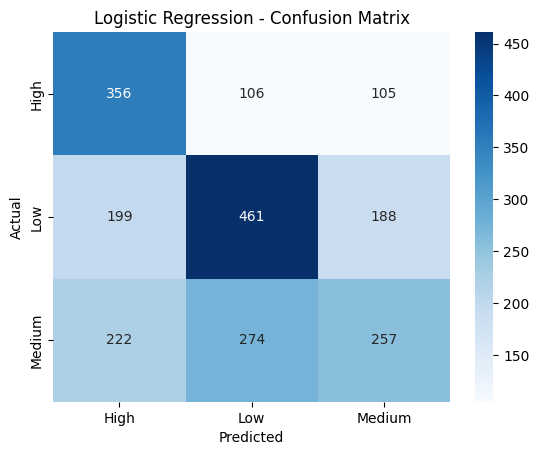

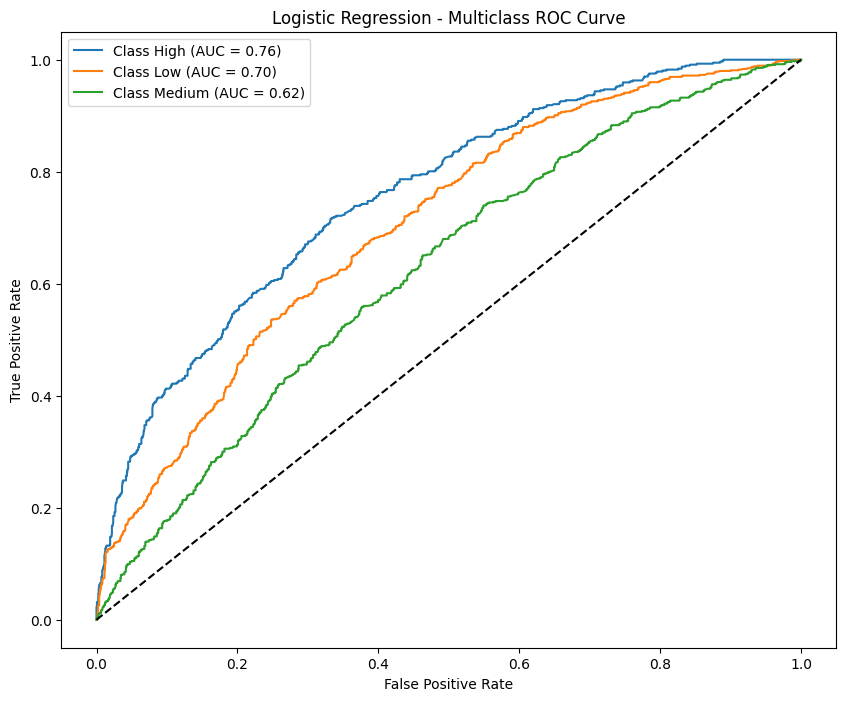

In [ ]:
# Get predicted probabilities for all classes
y_pred_proba_logreg = grid_search_logreg.best_estimator_.predict_proba(X_test)

# Plot confusion matrix for logistic regression
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
# Plot ROC curve for multiclass
class_names = label_encoder.classes_  # Retrieve original class names
plot_multiclass_roc(y_test, y_pred_proba_logreg, "Logistic Regression", class_names)


Insights:

- The Logistic Regression model achieved a macro F1-score of 0.49, indicating moderate performance in balancing precision and recall across all classes.
- The model performs best for the "Low" category with an F1-score of 0.55, but struggles significantly with the "Medium" class (F1-score of 0.39).
- The confusion matrix shows that the model has difficulty distinguishing between "Medium" and other categories, leading to misclassifications.

#### 4.4.2 Random Forest Classifier

In [ ]:
# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_

# Evaluate Random Forest
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Best Parameters (Random Forest): {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Random Forest Report:
               precision    recall  f1-score   support

        High       0.65      0.69      0.67       567
         Low       0.73      0.71      0.72       848
      Medium       0.56      0.56      0.56       753

    accuracy                           0.65      2168
   macro avg       0.65      0.65      0.65      2168
weighted avg       0.65      0.65      0.65      2168



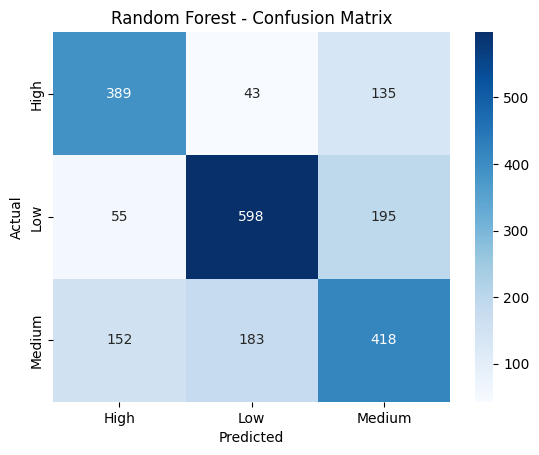

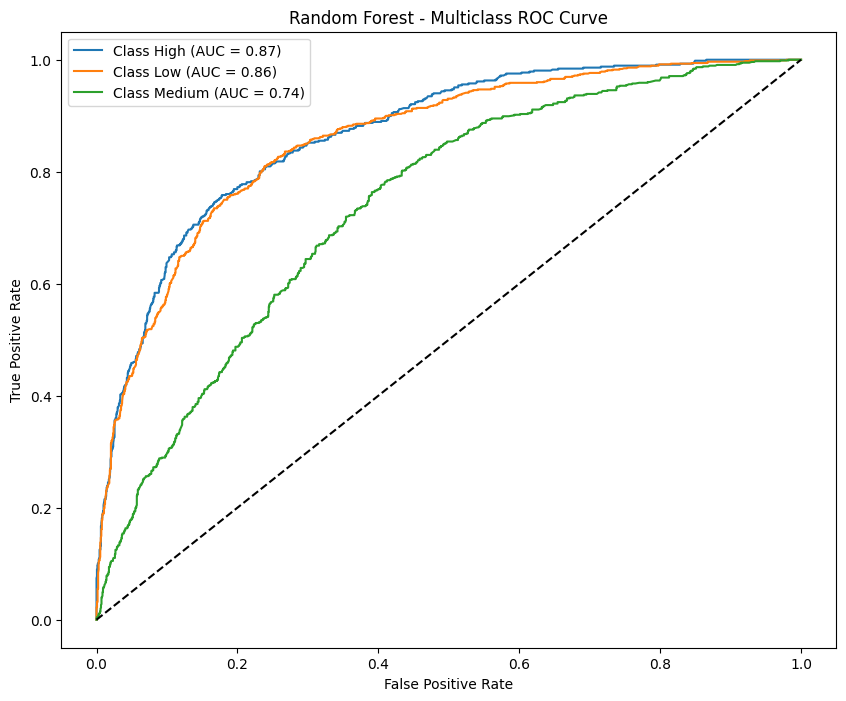

In [ ]:
#plots for rf
y_pred_proba_rf = grid_search_rf.best_estimator_.predict_proba(X_test)
# confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
# ROC curve
class_names = label_encoder.classes_
plot_multiclass_roc(y_test, y_pred_proba_rf, "Random Forest", class_names)


Insights;
- The Random Forest model achieved a macro F1-score of 0.65, showing significant improvement over Logistic Regression.
- It performs well across all classes, especially the "Low" category with an F1-score of 0.72.
- The model shows relatively balanced performance between precision and recall, making it a strong candidate for the final model.
- Misclassifications are fewer compared to Logistic Regression, as evidenced by the confusion matrix.

#### 4.4.3 XGBClassifier

In [ ]:
# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss'))
])

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 7]
}

# GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate XGBoost
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
print("Best Parameters (XGBoost):", grid_search_xgb.best_params_)
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))


Best Parameters (XGBoost): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
XGBoost Report:
               precision    recall  f1-score   support

        High       0.65      0.66      0.66       567
         Low       0.73      0.69      0.71       848
      Medium       0.54      0.57      0.56       753

    accuracy                           0.64      2168
   macro avg       0.64      0.64      0.64      2168
weighted avg       0.65      0.64      0.64      2168



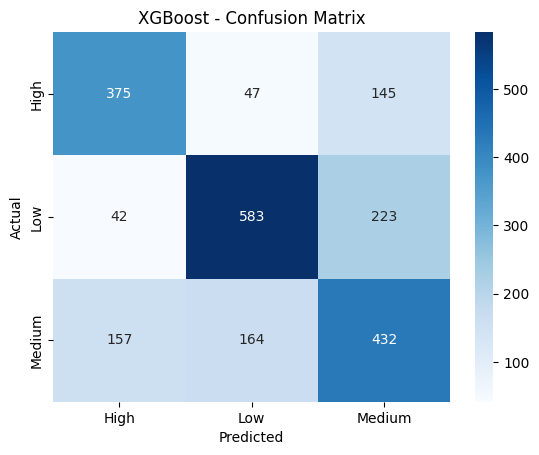

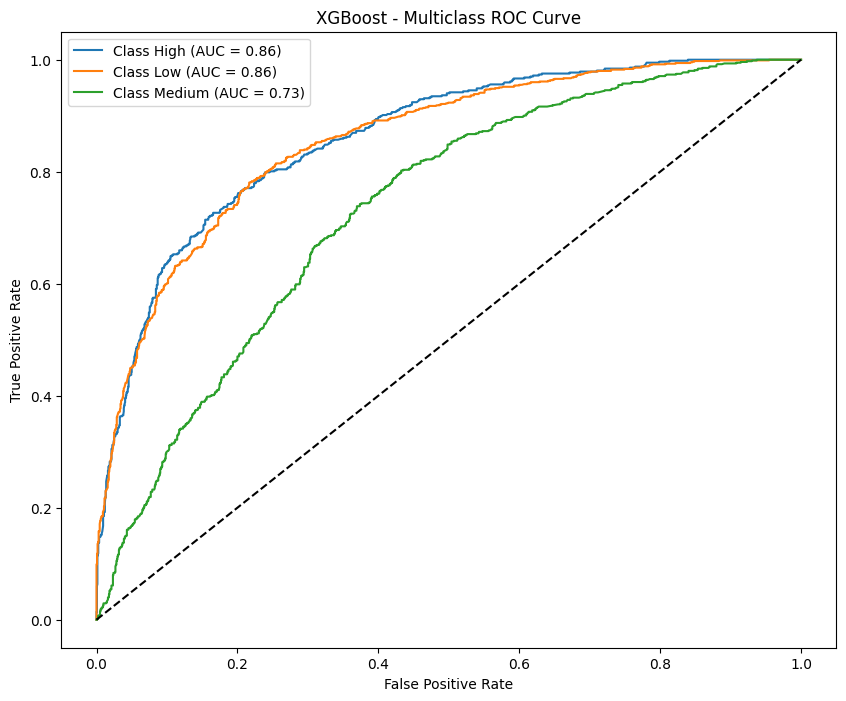

In [ ]:
#plots for xgb
y_pred_proba_xgb = grid_search_xgb.best_estimator_.predict_proba(X_test)
# confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
# ROC
class_names = label_encoder.classes_
plot_multiclass_roc(y_test, y_pred_proba_xgb, "XGBoost", class_names)

Insights;
- The XGBoost model achieved a macro F1-score of 0.64, which is comparable to the performance of the Random Forest model.
- It shows a strong performance for the "Low" category but slightly underperforms for the "Medium" category.
- The confusion matrix indicates some misclassifications, but the model handles class imbalance fairly well.

#### 4.4.4 LGBMClassifier

In [ ]:
# LGBM pipeline
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Hyperparameter grid for LGBM
lgbm_param_grid = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [5, 7, 10],
    'classifier__n_estimators': [100, 200],
    'classifier__num_leaves': [20, 31, 40]
}

# Set up GridSearchCV for LGBM
grid_search_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid=lgbm_param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_lgbm.fit(X_train, y_train)

best_lgbm_model = grid_search_lgbm.best_estimator_

#Evaluate lgbm
y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test)
print("Best Parameters (LightGBM):", grid_search_lgbm.best_params_)
print("LightGBM Report:\n", classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (LightGBM): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 40}
LightGBM Report:
               precision    recall  f1-score   support

        High       0.66      0.66      0.66       567
         Low       0.72      0.68      0.70       848
      Medium       0.54      0.57      0.55       753

    accuracy                           0.64      2168
   macro avg       0.64      0.64      0.64      2168
weighted avg       0.64      0.64      0.64      2168



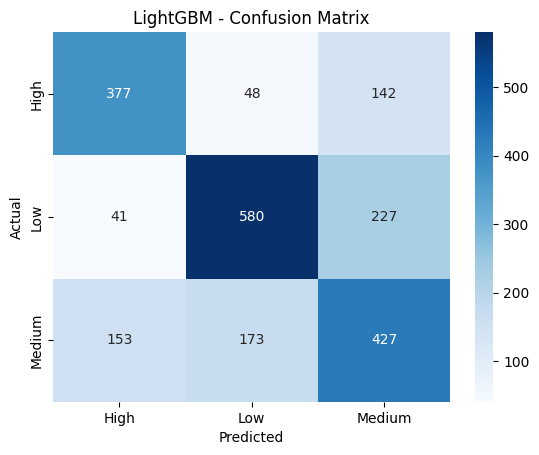

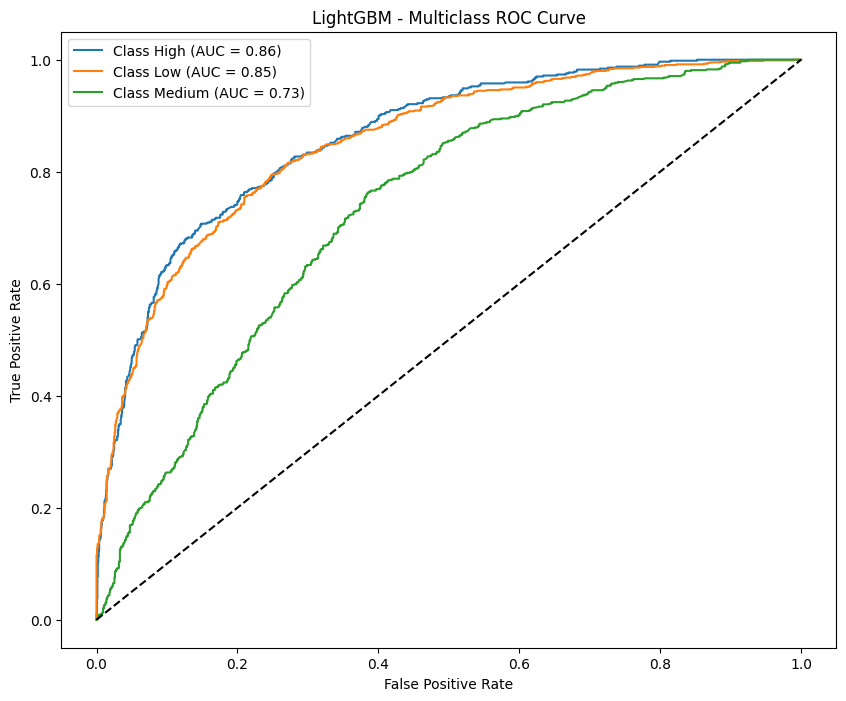

In [ ]:
#plots for lgbm
y_pred_proba_lgbm = grid_search_lgbm.best_estimator_.predict_proba(X_test)
# confusion matrix
plot_confusion_matrix(y_test, y_pred_lgbm, "LightGBM")
# ROC
class_names = label_encoder.classes_
plot_multiclass_roc(y_test, y_pred_proba_lgbm, "LightGBM", class_names)

Insights;
- The macro F1-score of 0.64 indicates that the model performs fairly well across all classes, treating each class equally, regardless of its size.
- The 'Low' class has the highest individual F1-score at 0.70, indicating the model's strength in identifying apps with low success.
- The 'Medium' class shows a relatively lower F1-score of 0.55, which could be due to overlap with other categories or fewer distinguishing features.


#### 4.4.5 Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model using the preprocessor pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define the model architecture
model = models.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_processed, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_dnn = model.predict(X_test_processed).argmax(axis=1)

# Generate classification report
from sklearn.metrics import classification_report, f1_score
print("DNN Classification Report:")
print(classification_report(y_test, y_pred_dnn, target_names=label_encoder.classes_))
print(f"Macro F1 Score (DNN): {f1_score(y_test, y_pred_dnn, average='macro')}")


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4216 - loss: 1.2187 - val_accuracy: 0.4888 - val_loss: 1.0117
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4857 - loss: 1.0150 - val_accuracy: 0.5256 - val_loss: 0.9605
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5326 - loss: 0.9464 - val_accuracy: 0.5389 - val_loss: 0.9192
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5483 - loss: 0.9278 - val_accuracy: 0.5516 - val_loss: 0.8865
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5544 - loss: 0.8965 - val_accuracy: 0.5550 - val_loss: 0.8753
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5523 - loss: 0.9029 - val_accuracy: 0.5827 - val_loss: 0.8631
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5510 - loss: 0.9027 - val_accuracy: 0.5798 - val_loss: 0.8593
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5715 - loss: 0.8755 - val_accurac

The macro F1-score of 0.60 shows the model performs reasonably well across all classes. The 'Low' class has the highest F1-score of 0.70, indicating strong performance in identifying low-success apps. The 'High' class follows with an F1-score of 0.64, while the 'Medium' class has a lower F1-score of 0.46, likely due to fewer samples or less distinct features. Improving feature differentiation for the 'Medium' class could enhance its performance.

#### 4.4.6 Ensemble methods

In [ ]:
from sklearn.ensemble import StackingClassifier


# Define base models with best-tuned parameters
base_estimators = [
    ('random_forest', RandomForestClassifier(
        bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('xgboost', XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=7, subsample=0.9, random_state=42, eval_metric='mlogloss')),
    ('lightgbm', LGBMClassifier(
        learning_rate=0.1, max_depth=7, num_leaves=40, subsample=0.7, random_state=42))
]

# Meta-classifier
meta_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Stacking model
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

# Create a pipeline that includes preprocessing and the stacking model
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_model)
])

# Fit the stacking pipeline on the full training set
stacking_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stack = stacking_pipeline.predict(X_test)

# Evaluate the performance of the Stacking Model
print("Stacking Model Classification Report:")
print(classification_report(y_test, y_pred_stack, target_names=['High', 'Low', 'Medium']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_stack)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Macro F1 Score
macro_f1_stack = f1_score(y_test, y_pred_stack, average='macro')
print(f"Macro F1 Score (Stacking Model): {macro_f1_stack:.4f}")


Stacking Model Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.63      0.66       567
         Low       0.74      0.73      0.73       848
      Medium       0.56      0.62      0.59       753

    accuracy                           0.66      2168
   macro avg       0.67      0.66      0.66      2168
weighted avg       0.67      0.66      0.66      2168

Confusion Matrix:
 [[356  44 167]
 [ 32 615 201]
 [117 172 464]]
Macro F1 Score (Stacking Model): 0.6607


The stacking model achieves a macro F1-score of 0.66, demonstrating good overall performance across all classes.

The 'Low' class has the highest F1-score of 0.73, indicating strong performance in identifying low-success apps.
The 'High' class has an F1-score of 0.66, showing decent performance in identifying successful apps.
The 'Medium' class has the lowest F1-score of 0.59, suggesting room for improvement in distinguishing medium-success apps.

In [ ]:
#save the best performing model(stacked)
joblib.dump(stacking_pipeline, 'stacking_model.joblib')

['stacking_model.joblib']

Model Evaluation and Comparison

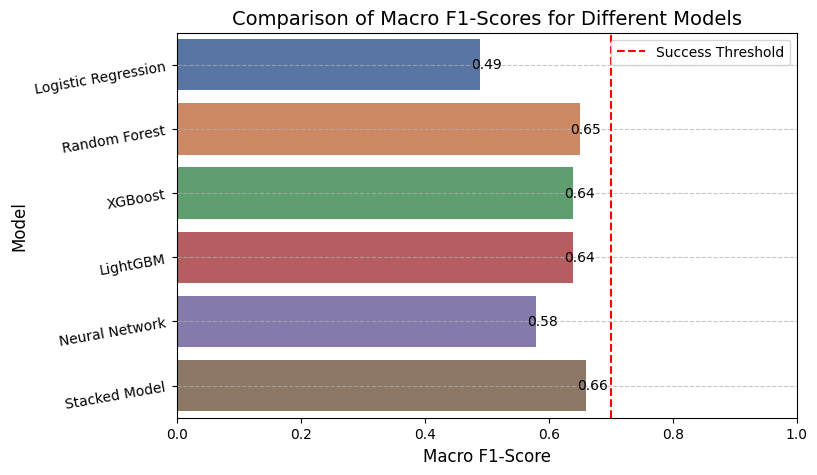

In [ ]:
# Macro F1-scores for the models
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network', 'Stacked Model']
macro_f1_scores = [0.49, 0.65, 0.64, 0.64, 0.58, 0.66]

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    'Model': model_names,
    'Macro F1-Score': macro_f1_scores
})

# Set up the plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Macro F1-Score', y='Model', data=results_df, hue='Model', palette='deep')

# Annotate the bar plot with the scores
for index, value in enumerate(macro_f1_scores):
    # Corrected line: Changed 'ha' to 'center'
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', ha='center')

# Customize the plot
plt.title('Comparison of Macro F1-Scores for Different Models', fontsize=14)
plt.xlabel('Macro F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.axvline(x=0.7, color='red', linestyle='--', label='Success Threshold')
plt.legend()
plt.xlim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks(rotation=10)

# Show the plot
plt.show()

- Both xgb and LightGBM models performed well, but the stacked model edged out slightly with a macro F1-score of 0.66.

In [ ]:
#download encoders and model
from google.colab import files
files.download('stacking_model.joblib')
files.download('label_encoder.joblib')
files.download('preprocessor.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
#download custom binary and ordinal transformers
files.download('binary_encoder_transformer.joblib')
files.download('ordinal_encoder_transformer.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **5. Justification**
Our best-performing model, the Stacking Model, demonstrates robust predictive power despite not fully reaching the 0.7 Macro F1-score target, achieving a respectable 0.66. This performance is particularly noteworthy due to the balanced precision and recall observed across all install categories (High, Low, Medium). The model exhibits precision and recall rates ranging from 0.56 to 0.74 across these categories, signifying its consistent ability to correctly identify apps belonging to each category without significant bias. This balanced performance, even without achieving the target metric, underscores the model's reliability and potential for real-world application in predicting app success

## **6. Recommendation**

* Focus on Free Apps: The analysis clearly shows that free apps consistently attract more installs than paid apps. Developers should prioritize a freemium model or completely free apps to maximize their reach and user engagement.

* Target "Everyone" Content Rating: Apps targeting a broader audience (rated "Everyone") tend to have the highest number of installs. Developers should ensure their apps are accessible to a wide range of users to boost installs, especially by aiming for this category.

* Optimize App Size: While smaller app sizes (under 10MB) are popular among users, the "Varies with device" category also suggests the need for flexibility in app design. Developers should strive to maintain an optimal balance between features and app size, ideally under 50MB, to cater to a larger audience.

* Pricing Strategy: While most apps are free, there is a segment of paid apps that do well. To succeed in this area, developers must add premium features or services that justify the app's price.

## **7. Conclusion**

The analysis provides valuable insights into the factors influencing app success, such as app type, category, content rating, and size. By aligning app development strategies with these factors, developers can increase their chances of success in a competitive market. Models like Random Forest and XGBoost show strong performance in classifying app success, indicating their potential for use in predictive modeling for app performance.